# Micro- and Macroeconomic Implications of Very Impatient Households

<p style="text-align: center;"><small><small><small>Generator: QuARK-make/notebooks_byname</small></small></small></p>

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/micro-and-macro-implications-of-very-impatient-hhs#launch)

## Introduction

Buffer stock saving models of the kind implemented in $\texttt{ConsIndShockType}$ say that, if a standard ['Growth Impatience Condition'](https://econ-ark.github.io/BufferStockTheory/#GICRaw), holds:

\begin{eqnarray}
\newcommand{\Rfree}{\mathsf{R}}\newcommand{\DiscFac}{\beta}\newcommand{\PermGroFac}{\Gamma}\newcommand{\PermShk}{\psi}\newcommand{\CRRA}{\rho}
\left(\frac{(\Rfree\DiscFac)^{1/\CRRA}\mathbb{E}[\PermShk^{-1}]}{\PermGroFac}\right) & < & 1
\end{eqnarray}

then the _ratio_ of asets $\newcommand{\aLev}{\mathbf{a}}\aLev$ to permanent income $\newcommand{\pLev}{\mathbf{p}}\pLev$, $a=\aLev/\pLev$, has a target value $\newcommand{\aTarg}{\check{a}}\aTarg$ that depends on the consumer's preferences (relative risk aversion $\CRRA$, time preference $\DiscFac$) and circumstances (interest factor $\Rfree$, growth factor $\PermGroFac$, uncertainty about permanent income shocks $\sigma^{2}_{\PermShk}$).

If everyone had identical preferences and everyone were at their target $\check{a}$, then inequality in the level of $\aLev$ would be exactly the same as inequality in $\pLev$.

["The Distribution of Wealth and the Marginal Propensity to Consume"](https://www.econ2.jhu.edu/people/ccarroll/papers/cstwMPC) (Carroll, Slacalek, Tokuoka, and White 2017; hereafter: "cstwMPC") shows that, when such a model is simulated and agents draw their idiosyncratic shocks (so, agents are _ex post_ heterogeneous -- see the definition in [Intro-To-HARK](http://github.com/econ-ark/PARK/tree/master/Intro-To-HARK.pdf)) -- asset inequality is indeed close to $\pLev$ inequality even though everyone is not always at exactly their target $a$.

But a large body of evidence shows that _actual_ inequality in assets is much greater than _actual_ inequality in permanent income.  Thus, to make a model that qualifies as what cstwMPC call a 'serious' microfounded macro model of consumption (one that matches the key facts _theory says_ should be first-order important), the model must be modified to incorporate some form of _ex ante_ heterogeneity: That is, there must be differences across people in $\DiscFac$ or $\Rfree$ or $\CRRA$ or $\PermGroFac$ or $\sigma^{2}_{\PermShk}$.

The most transparent and simplest of these to change is the time preference factor $\beta$.  So that is what the paper does.  The main results are:

1. The distribution of $\beta$ need not be particularly wide to match the extreme concentration of wealth: roughly 0.91 to 0.98 (annual); that is, the most impatient person discounts the future about 6 percentage points more per year than the most patient agent agent
2. With such a distribution of $\beta$, simulated agents' (annual) marginal propensity to consume (MPC) from transitory income shocks to income matches large body of microeconomic evidence that typically finds evidence of MPC's in the range of 0.2 to 0.6.  This is much better than RA macro models that typically yield MPC's in the range of 0.01 to 0.05.

While the most impatient agents in the cstwMPC model have fairly high MPCs (~0.6 annual), there is microeconomic evidence that a significant fraction of households have *even higher* MPCs than the model predicts, especially at the quarterly frequency.  This group of households is commonly referred to as "hand-to-mouth" -- they consume most of their transitory shocks to income not too long after they receive them (mostly within a quarter).  There are several reasons why a household could be hand-to-mouth, but one plausible explanation is that these households are *even more impatient* than estimated by cstwMPC for the most impatient agent.


In [1]:
# This cell does some setup and imports generic tools used to produce the figures

from HARK.utilities import get_lorenz_shares, get_percentiles
from HARK.datasets import load_SCF_wealth_weights
from HARK.distribution import Uniform
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from copy import deepcopy
import warnings
from distutils.spawn import find_executable
import matplotlib.pyplot as plt
from IPython import get_ipython  # In case it was run from python instead of ipython
from tqdm import tqdm

import numpy as np
from copy import deepcopy


Generator = False  # Is this notebook the master or is it generated?
# Import related generic python packages

# Set how many digits past the decimal point should be printed?


def mystr(number):
    return "{:.4f}".format(number)


def decfmt4(number):
    return "{:.4f}".format(number)


def decfmt3(number):
    return "{:.3f}".format(number)


def decfmt2(number):
    return "{:.2f}".format(number)


def decfmt1(number):
    return "{:.1f}".format(number)


# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"


def in_ipynb():
    try:
        if (
            str(type(get_ipython()))
            == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>"
        ):
            return True
        else:
            return False
    except NameError:
        return False


# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic("matplotlib", "inline")
else:
    get_ipython().run_line_magic("matplotlib", "auto")

# Import the plot-figure library matplotlib


# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.

plt.rc("font", family="serif")

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it

iflatexExists = False
if find_executable("latex"):
    iflatexExists = True

plt.rc("text", usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages

warnings.filterwarnings("ignore")

## Calibrating a Basic Version of cstwMPC

To get started, let's reproduce a simplified version of the main results from cstwMPC.

In cstwMPC, the authors calibrated nearly all of the model parameters-- risk aversion, income shock process, etc-- to commonly used or previously estimated values.  The only parameter to be estimated is the distribution of $\beta$.  cstwMPC assumed that $\beta$ is uniformly distributed on $[\grave{\beta}-\nabla,\grave{\beta}+\nabla]$, approximated by a seven point distribution.

Their estimation procedure seeks the values of $\grave{\beta}$ and $\nabla$ that generate a simulated distribution of wealth that best matches empirical U.S. data.  Their definition of "best match" has two aspects:

1. The simulated aggregate capital-to-income ratio matches the true U.S. value.
2. The sum of squared distances between the simulated and empirical Lorenz curves (at the 20th, 40th, 60th, and 80th percentiles) is minimized (conditional on item 1).

cstwMPC's target empirical moments are a capital-to-income ratio of 10.26 and cumulative wealth shares as given in the table below.  Yes, you are reading the table correctly: The "poorest" 80 percent of households own 17.5 percent of wealth.

| Net worth percentile | Cumulative wealth share |
|:---:|:---:|
|  20th  | -0.2% |
|  40th  | 1.0% |
|  60th  | 5.5% |
|  80th  | 17.5% |

To reproduce their basic results, we must import an $\texttt{AgentType}$ subclass and define a dictionary with calibrated parameters identical to those in the paper.

In [2]:
# Import IndShockConsumerType

# Define a dictionary with calibrated parameters
cstwMPC_calibrated_parameters = {
    "CRRA": 1.0,  # Coefficient of relative risk aversion
    "Rfree": 1.01 / (1.0 - 1.0 / 160.0),  # Survival probability,
    # Permanent income growth factor (no perm growth),
    "PermGroFac": [1.000**0.25],
    "PermGroFacAgg": 1.0,
    "BoroCnstArt": 0.0,
    "CubicBool": False,
    "vFuncBool": False,
    "PermShkStd": [
        (0.01 * 4 / 11) ** 0.5
    ],  # Standard deviation of permanent shocks to income
    "PermShkCount": 5,  # Number of points in permanent income shock grid
    "TranShkStd": [
        (0.01 * 4) ** 0.5
    ],  # Standard deviation of transitory shocks to income,
    "TranShkCount": 5,  # Number of points in transitory income shock grid
    "UnempPrb": 0.07,  # Probability of unemployment while working
    "IncUnemp": 0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet": 0.07,
    "IncUnempRet": 0.15,
    "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax": 40,  # Maximum end-of-period assets in grid
    "aXtraCount": 32,  # Number of points in assets grid
    "aXtraExtra": [None],
    "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
    "DiscFac": 0.97,  # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles": 0,
    "T_cycle": 1,
    "T_retire": 0,
    # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    "T_sim": 1200,
    "T_age": 400,
    "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
    "aNrmInitMean": np.log(0.00001),
    "aNrmInitStd": 0.0,
    "pLvlInitMean": 0.0,
    "pLvlInitStd": 0.0,
    "AgentCount": 10000,
}

Now let's make several instances of our class of agents and give them different values of $\beta$, following cstwMPC's estimated distribution.  In our specification of interest, we will use $\grave{\beta}=0.9855583$ and $\nabla = 0.0085$.

NB: Reported parameter estimates in cstwMPC use a model with aggregate shocks and wage and interest rates determined dynamically (a heterogeneous agents DSGE model); this is the $\texttt{AggShockConsumerType}$ in HARK.  The estimated parameters are slightly different in this exercise, as we are ignoring general equilibrium aspects and only using the $\texttt{IndShockConsumerType}$

In [3]:
# This cell constructs seven instances of IndShockConsumerType with different discount factors

from HARK.core import AgentPopulation

# Specify the distribution of the discount factor
num_types = 7  # number of types we want
DiscFac_mean = 0.9855583  # center of beta distribution
DiscFac_spread = 0.0085  # spread of beta distribution

cstwMPC_calibrated_parameters["DiscFac"] = Uniform(DiscFac_mean - DiscFac_spread, DiscFac_mean + DiscFac_spread)

MyTypes = AgentPopulation(IndShockConsumerType, cstwMPC_calibrated_parameters)
MyTypes.approx_distributions({"DiscFac": num_types})
MyTypes.create_distributed_agents()



## Solving and Simulating the Baseline Agents

Now let's solve and simulate each of our types of agents.  If you look in the parameter dictionary (or at any of the agent objects themselves), you will see that each one has an $\texttt{AgentCount}$ attribute of 10000. That is, these seven ex ante heterogeneous types each represent ten thousand individual agents that will experience ex post heterogeneity when they draw different income (and mortality) shocks over time.

In the code block below, fill in the contents of the loop to solve and simulate each agent type for many periods.  To do this, you should invoke the methods $\texttt{solve}$, $\texttt{initialize_sim}$, and $\texttt{simulate}$ in that order.  Simulating for 1200 quarters (300 years) will approximate the long run distribution of wealth in the population.

In [4]:
MyTypes.solve()
MyTypes.initialize_sim()
MyTypes.simulate()

GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974572 
WRPF                   = 0.068220 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999206 
GPFNrm                 = 1.002470 
GPFAggLivPrb           = 0.992961 
Thorn = APF            = 0.999206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976985 
WRPF                   = 0.068389 
DiscFacGPFNrmMax    

To verify that you wrote that code correctly, let's check that the aggregate level of capital (total assets held by all households) to income ratio equals what we expected it would be.  To do that, let's combine the asset holdings of all types, take the mean, and see if we get the desired capital to income ratio of 10.26.

NB: Because there is no permanent income growth in this model, all shocks are mean one and idiosyncratic, and we have many agents, aggregate or average income is 1.0.

In [5]:
aLvl_all = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])
print(
    "The ratio of aggregate capital to permanent income is "
    + decfmt2(np.mean(aLvl_all))
)

The ratio of aggregate capital to permanent income is 10.29


## Plotting the Lorenz Curve

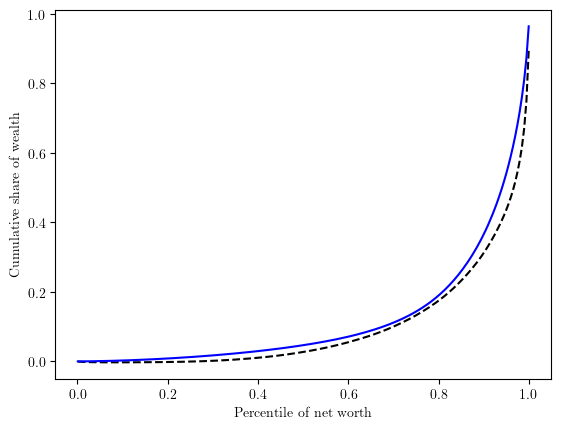

In [6]:
# Plot Lorenz curves for model with uniform distribution of time preference

SCF_wealth, SCF_weights = load_SCF_wealth_weights()

pctiles = np.linspace(0.001, 0.999, 200)
sim_wealth = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)
plt.plot(pctiles, SCF_Lorenz_points, "--k")
plt.plot(pctiles, sim_Lorenz_points, "-b")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.show(block=False)

## Calculating the Lorenz Distance at Targets

Now we want to construct a function that calculates the Euclidean distance between simulated and actual Lorenz curves at the four percentiles of interest: 20, 40, 60, and 80.

## The Distribution Of the Marginal Propensity to Consume

For many macroeconomic purposes, the distribution of the MPC $\kappa$ is more important than the distribution of wealth.  Ours is a quarterly model, and MPC's are typically reported on an annual basis; we can compute a (very) approximate annual MPC from the quraterly ones as $\kappa_{Y} \approx 1.0 - (1.0 - \kappa_{Q})^4$

In the cell below, we retrieve the MPCs from our simulated consumers and show that the 10th percentile in the MPC distribution is only about 6 percent, while at the 90th percentile it is almost 0.5

In [7]:
# Retrieve the MPC's
percentiles = np.linspace(0.1, 0.9, 9)
MPC_sim = np.concatenate([ThisType.MPCnow for ThisType in MyTypes])
MPCpercentiles_quarterly = get_percentiles(MPC_sim, percentiles=percentiles)
MPCpercentiles_annual = 1.0 - (1.0 - MPCpercentiles_quarterly) ** 4

print(
    "The MPC at the 10th percentile of the distribution is "
    + str(decfmt2(MPCpercentiles_annual[0]))
)
print(
    "The MPC at the 50th percentile of the distribution is "
    + str(decfmt2(MPCpercentiles_annual[4]))
)
print(
    "The MPC at the 90th percentile of the distribution is "
    + str(decfmt2(MPCpercentiles_annual[-1]))
)

The MPC at the 10th percentile of the distribution is 0.06
The MPC at the 50th percentile of the distribution is 0.20
The MPC at the 90th percentile of the distribution is 0.51


## Adding Very Impatient Households

Now that we have some tools for examining both microeconomic (the MPC across the population) and macroeconomic (the distribution and overall level of wealth) outcomes from our model, we are all set to conduct our experiment.

In this exercise, we are going to add very impatient households to the economy in a very direct way: by replacing the *most impatient consumer type* with an *even more impatient type*.  Specifically, we will have these agents have a discount factor of $\beta = 0.80$ at a quarterly frequency, which corresponds to $\beta \approx 0.41$ annual.

In the code block below, we:

1. Replicate the list of agents using $\texttt{deepcopy}$.
2. Set the $\beta$ of the most impatient type to $0.80$ (for the copied set of agents).
3. Solve and simulate the most impatient type (for the copied set of agents).

In [8]:
# Follow the instructions above to make another list of agents that includes *very* impatient households.
NewTypes = deepcopy(MyTypes)
NewTypes[0].DiscFac = 0.8
NewTypes[0].solve()
NewTypes[0].initialize_sim()
NewTypes[0].simulate()

# Retrieve the MPC's
percentiles = np.linspace(0.1, 0.9, 9)
MPC_sim = np.concatenate([ThisType.MPCnow for ThisType in NewTypes])
MPCpercentiles_quarterly = get_percentiles(MPC_sim, percentiles=percentiles)
MPCpercentiles_annual = 1.0 - (1.0 - MPCpercentiles_quarterly) ** 4

print(
    "The MPC at the 10th percentile of the distribution is "
    + str(decfmt2(MPCpercentiles_annual[0]))
)
print(
    "The MPC at the 50th percentile of the distribution is "
    + str(decfmt2(MPCpercentiles_annual[4]))
)
print(
    "The MPC at the 90th percentile of the distribution is "
    + str(decfmt2(MPCpercentiles_annual[-1]))
)

GPFRaw                 = 0.813082 
GPFNrm                 = 0.815738 
GPFAggLivPrb           = 0.808000 
Thorn = APF            = 0.813082 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.795000 
WRPF                   = 0.055650 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


The MPC at the 10th percentile of the distribution is 0.06
The MPC at the 50th percentile of the distribution is 0.20
The MPC at the 90th percentile of the distribution is 0.97
